# Phase 4 Part 1 Review!


1. Recommendation Systems
2. Unsupervised Techniques
3. Manipulating Time Series Data


## 1) Recommendation Systems

### Three Main Types

- non-personalized
- content-based
- collaborative filtering

### Non-Personalized Recommendations

<img src="images/youtube-nonpersonalizedrecommendations.png" width=600>

YouTube is notorious for putting non-personalized content on their homepage (although they tailor recommendations in other places)

These recommendations are based purely on the popularity of the item!

#### Advantages
- Super easy (computationally and for the user to understand)
- Items are usually popular for a reason
- No cold-start issue

#### Disadvantages
- Not personalized
- New items won’t gain traction

### Content-Based

<img src="images/spotify-contentrecommendations.png" width=600>

[Image Source](https://www.howtogeek.com/393291/already-a-spotify-fan-here-are-6-new-features-you-might-have-missed/)

Content-based recommendations are based on the properties/attributes of the items, where the items you've rated highly (or, in Spotify's case, listened to recently or often) are then compared against the properties/attributes of other items, and those items are then recommended if they're considered 'similar'.

What items are 'similar'? Depends on your similarity metric:

<img src="images/similaritymetrics.png" width=750>

[Image Source: "What Similarity Metric Should You Use for Your Recommendation System?](https://medium.com/bag-of-words/what-similarity-metric-should-you-use-for-your-recommendation-system-b45eb7e6ebd0) <- useful reading!

Those are just 3 examples, there are others (Jaccard index, Euclidian similarity) - but the point is you take some mathematical understanding of the items and find which ones are 'nearby' in some sense.

#### Advantages:
- Easy and transparent
- No cold start issue
- Recommend items to users with unique tastes

#### Disadvantages:
- Requires some type of tagging of items
- Overspecialization to certain types of items

## Collaborative Filtering

![collaborative filtering utility matrix example](images/collaborativefiltering.png)

[Image Source](https://www.incubegroup.com/blog/recommender-system-for-private-banking/)

Use both User and Item data! Use past behavior of many users (how they've rated many items) to find similarities either between users or between items (either user-based or item-based) to recommend new things.

We build a Utility/Rating Matrix to capture many users' ratings of many different items - a matrix that, in practice, tends to be quite _sparse_ (see all the blanks in just this tiny example above).

Then, we use **_MATH_** (namely, matrix factorization) to fill in those blanks, based upon similar users' ratings of similar items.

More specifically, it finds factor matrices which result in the ratings it has - decomposing the actual Utility Matrix into component pieces that explain it. These component pieces, matrices themselves, can be thought of as 'latent' or 'inherent' features of the items and users! The math then comes in, as we calculate the dot products in order to arrive at our predicted ratings.'

<img src="images/matrixfactorization.png" alt="matrix factorization image, showing the factor matrices" width=700>

[Image Source](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)

A bit more on Matrix Factorization, from Google's Recommendations Systems crash course: https://developers.google.com/machine-learning/recommendation/collaborative/matrix

#### Advantages:
- Personalized. You’re special!

#### Disadvantages:
- Can require a lot of computation, especially as these matrices get larger
- Cold start: need to have a lot of ratings to be worthwhile
- Popularity Bias: biased towards items that are popular. May not capture people’s unique tastes.

Matrix factorization methods include Singular Value Decomposition (SVD) and Alternating Least Squares (ALS)

I'll note that there are differences between _explicit_ and _implicit_ ratings.

- **_Explicit_** data is gathered from users when we ask a user to rate an item on some scale
    - Pros: concrete rating system, can assume users actually feel the way they input and thus can extrapolate from those preferences
    - Cons: not all users might input their preferences
- **_Implicit_** data is gathered from users without their direct input - a system logs the actions of a user
    - Pros: Easier to collect automatically, thus have more data from more users without those users needing to go through extra steps
    - Cons: More difficult to work with - how do we know what actions imply preference?
    
[insert comment about y'all filling out surveys here]

[Resource](https://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/collaborativefiltering.html#:~:text=Implicit%20Data%20Collection,system%20has%20to%20collect%20data.&text=Explicit%20data%20gathering%20is%20easy,data%20to%20predict%20future%20ratings.)

### And now, in code!

#### Data Source:

https://www.kaggle.com/rounakbanik/the-movies-dataset

In [1]:
# Import libraries, round 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load in data and check it out
rating_df = pd.read_csv('data/ratings.csv') 
print(rating_df.shape) 
rating_df.head(10) 

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
# Can also get the data straight from the surprise library we'll be using
# from surprise import Dataset
# data = Dataset.load_builtin('ml-100k')
# rating_df = pd.read_csv('~/.surprise_data/ml-100k/ml-100k/u.data',
#             sep='\t', header=None)
# rating_df = rating_df.rename(columns={0: 'user', 1: 'item', 2: 'rating', 3: 'timestamp'})

### Singular Value Decomposition using Surprise

Huge shoutout to my colleague Yish for the bulk of this section's content!

One of the easiest libraries to use for recommendation systems is Surprise, which stands for **Simple Python Recommendation System Engine**. Here, we'll code a recommendation system using the Surprise Library's Singular Value Decomposition (SVD) algorithm.

To read more about Surprise's SVD implementation, and its hyperparameters:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [4]:
# If you need the surprise library
# !pip install surprise

In [5]:
# Import libraries, round 2
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

In [6]:
# for Surprise, we only need three columns from the dataset
data = rating_df[['userId', 'movieId', 'rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

# train-test-split
trainset, testset = train_test_split(data, test_size=.2)

In [7]:
# instantiate SVD and fit the trainset
svd = SVD() # default values
svd.fit(trainset)

In [8]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9065


0.906548057504164

### Making Predictions

In [9]:
# taking a look at the first 10 rows of our test set
predictions[:10]

[Prediction(uid=201, iid=8368, r_ui=5.0, est=4.169155874925655, details={'was_impossible': False}),
 Prediction(uid=432, iid=2959, r_ui=5.0, est=4.908068584279139, details={'was_impossible': False}),
 Prediction(uid=518, iid=3081, r_ui=4.0, est=3.9626968081123137, details={'was_impossible': False}),
 Prediction(uid=341, iid=4404, r_ui=1.0, est=3.798572520816769, details={'was_impossible': False}),
 Prediction(uid=564, iid=2947, r_ui=4.0, est=3.7535045523653183, details={'was_impossible': False}),
 Prediction(uid=4, iid=3071, r_ui=4.0, est=4.418271949515556, details={'was_impossible': False}),
 Prediction(uid=468, iid=4980, r_ui=2.5, est=2.7794518349378547, details={'was_impossible': False}),
 Prediction(uid=157, iid=59814, r_ui=4.5, est=3.278980467908251, details={'was_impossible': False}),
 Prediction(uid=39, iid=426, r_ui=3.0, est=3.6065629464307825, details={'was_impossible': False}),
 Prediction(uid=380, iid=96110, r_ui=3.0, est=3.413587793036456, details={'was_impossible': False})

In [10]:
print("Number of users: ", rating_df.userId.nunique()) 
print("Number of movies: ", rating_df.movieId.nunique()) 

Number of users:  671
Number of movies:  9066


In [11]:
user = 5
item = 141
svd.predict(user, item)

Prediction(uid=5, iid=141, r_ui=None, est=3.8950277190475746, details={'was_impossible': False})

-----

## 2) Unsupervised Learning

![unsupervised learning intro image compared to other ml types, from math works](images/machinelearning_unsupervised.png)

[Image Source](https://fr.mathworks.com/help/stats/machine-learning-in-matlab.html)

## Principal Component Analysis (PCA)

#### Type of Learning
- Unsupervised

#### Assumptions
- Correlation among features

#### Advantages
- Captures most of the variance in a smaller number of features

#### Disadvantages
- Number of principal components that explain most of the variance are determined by the USER

#### Requirements 

- Features must be scaled (StandardScaler)
- Sensitive to missing data.
- Sensitive to outliers.

#### Example Use
- Reducing feature space
- Preprocessing
- Creating a few, informative variables from tons of data

#### Curse of Dimensionality?

Reading: [In-Depth Article About the Curse of Dimensionality](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)

| Over-Fitting | Better Fit (but worse results) | 
| ---- | ---- |
| ![overfitting image from the above post](https://www.visiondummy.com/wp-content/uploads/2014/04/overfitting.png) | ![better fit image from the same post](https://www.visiondummy.com/wp-content/uploads/2014/04/no_overfitting.png) |


#### How does PCA solve this?

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-pca-in-scikitlearn-online-ds-sp-000/master/images/inhouse_pca.png">

PCA finding the right component direction:

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-unsupervised-learning-online-ds-pt-100719/master/images/pca.gif">

### ACTIVITY: USING PCA TO COLLAPSE 1800+ HEALTH FEATURES TO 10

Huge shoutout to my colleague James for the bulk of this section's content!

#### Data
- [NHANES Dataset](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey)
    
- [Complete variable list](https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Demographics&CycleBeginYear=2013)

In [12]:
# Imports round 3!
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

np.random.seed(123)

In [13]:
import os, sys

# Notebook Folderpath
folder = 'data/NHANES/'
os.listdir(folder)

['medications.csv',
 'diet.csv',
 'examination.csv',
 'demographic.csv',
 'labs.csv',
 'questionnaire.csv']

In [14]:
# Use glob to get list of csvs
import glob
files = glob.glob(folder+'*.csv')
files

['data/NHANES/medications.csv',
 'data/NHANES/diet.csv',
 'data/NHANES/examination.csv',
 'data/NHANES/demographic.csv',
 'data/NHANES/labs.csv',
 'data/NHANES/questionnaire.csv']

In [15]:
# Load in all CSVs combined 
nhanes_df = pd.concat([pd.read_csv(file, index_col='SEQN') for file in files[1:]],axis=1)
nhanes_df.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,16888.327864,12930.890649,1.0,49.0,2.0,2.0,6.0,2.0,1.0,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
73558,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,1.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
73559,59641.812930,39394.236709,1.0,49.0,2.0,2.0,18.0,6.0,1.0,1.0,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
73560,142203.069917,125966.366442,1.0,54.0,2.0,2.0,21.0,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
73561,59052.357033,39004.892993,1.0,63.0,2.0,2.0,18.0,1.0,1.0,1.0,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In [16]:
nhanes_df.shape

(10175, 1811)

### Task: Compress 1,800+ features down to 3 using PCA.

#### First: need to explore and define our column groups

In [17]:
# Some columns are mostly null data - let's explore
num_rows = len(nhanes_df)
high_null_cols = []

for column in nhanes_df.columns:
    num_nulls = nhanes_df[column].isna().sum()
    perc_nulls = num_nulls / num_rows
    if perc_nulls > .75:
        high_null_cols.append(column)

In [18]:
len(high_null_cols)

848

In [19]:
# Get a list of categorical columns 
cat_cols = [c for c in nhanes_df.select_dtypes('object').columns if c not in high_null_cols]
cat_cols

['OHX02CTC',
 'OHX03CTC',
 'OHX04CTC',
 'OHX05CTC',
 'OHX06CTC',
 'OHX07CTC',
 'OHX08CTC',
 'OHX09CTC',
 'OHX10CTC',
 'OHX11CTC',
 'OHX12CTC',
 'OHX13CTC',
 'OHX14CTC',
 'OHX15CTC',
 'OHX18CTC',
 'OHX19CTC',
 'OHX20CTC',
 'OHX21CTC',
 'OHX22CTC',
 'OHX23CTC',
 'OHX24CTC',
 'OHX25CTC',
 'OHX26CTC',
 'OHX27CTC',
 'OHX28CTC',
 'OHX29CTC',
 'OHX30CTC',
 'OHX31CTC',
 'CSXTSEQ']

<AxesSubplot:>

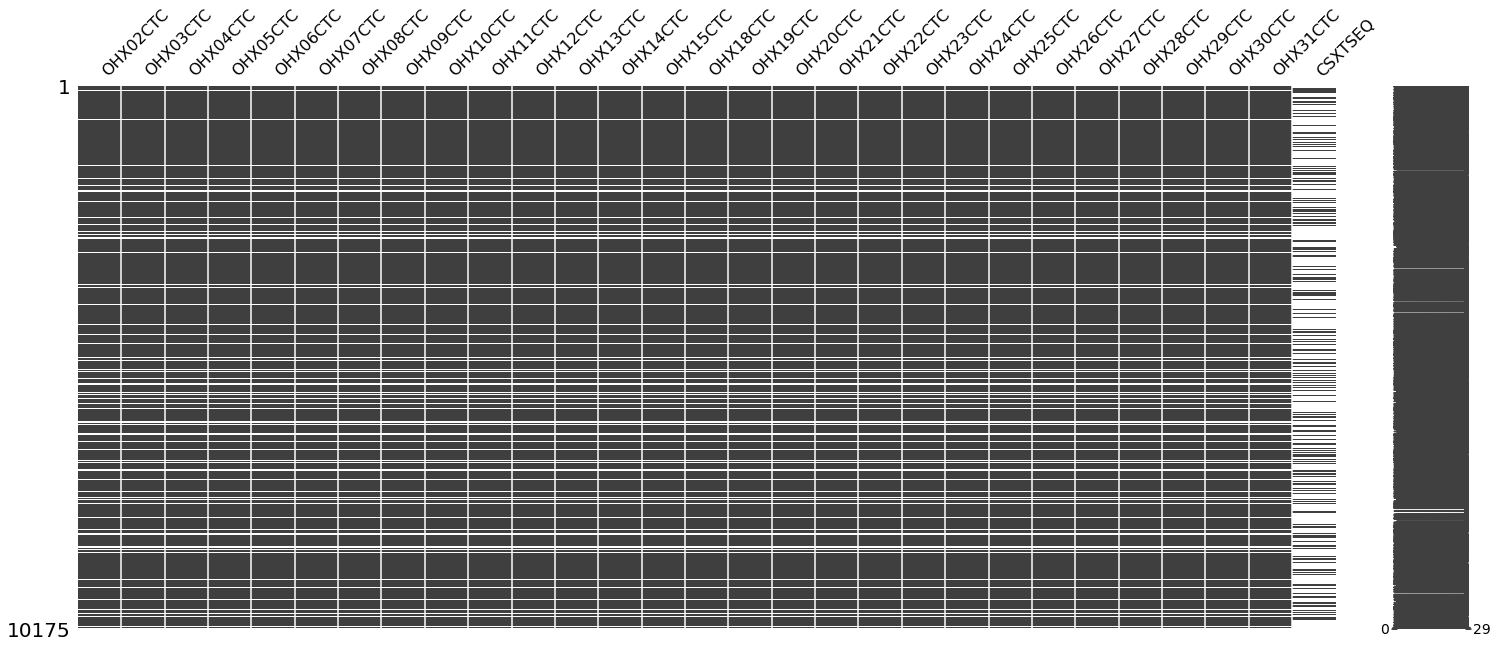

In [20]:
# Explore those categorical columns
import missingno

missingno.matrix(nhanes_df[cat_cols])

In [21]:
nhanes_df[cat_cols].describe()

,OHX02CTC,OHX03CTC,OHX04CTC,OHX05CTC,OHX06CTC,OHX07CTC,OHX08CTC,OHX09CTC,OHX10CTC,OHX11CTC,...,OHX23CTC,OHX24CTC,OHX25CTC,OHX26CTC,OHX27CTC,OHX28CTC,OHX29CTC,OHX30CTC,OHX31CTC,CSXTSEQ
count,8965,8965,8965,8965,8965,8965,8965,8965,8965,8965,...,8965,8965,8965,8965,8965,8965,8965,8965,8965,3234
unique,11,12,12,14,13,14,14,14,13,13,...,12,12,13,13,12,13,13,11,11,2
top,S,S,S,S,S,S,S,S,S,S,...,S,S,S,S,S,S,S,Z,Z,B
freq,2637,3230,3777,3997,5165,5322,5473,5500,5312,5123,...,6734,6991,6964,6719,6044,5045,4148,2955,2735,1658


In [22]:
# Now a list of the rest of columns, which should all be numeric
num_cols = [c for c in nhanes_df.columns if c not in [*cat_cols, *high_null_cols]]

In [23]:
len([*num_cols, *cat_cols, *high_null_cols]) == len(nhanes_df.columns)

True

#### Pipeline!

In [24]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

high_nulls_transformer = Pipeline(steps=[
    ('null_indicator', MissingIndicator())])

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', ohe_transformer, cat_cols), 
        ('null', high_nulls_transformer, high_null_cols)])

In [26]:
# Fit transform just to check what it'll look like
processed_data = pd.DataFrame(preprocessor.fit_transform(nhanes_df))

processed_data.shape

(10175, 2162)

In [27]:
# Add PCA
n_components = 20

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('pca',PCA(n_components))])

*You could put `n_components=.6` if we want our model to explain at least 60% of the variance. When she put this code in, she got 21 components*

In [28]:
# Extract the Principal Components from the pipeline 
pc_data = pipe.fit_transform(nhanes_df)

# Verify the # of features
pc_data.shape

(10175, 20)

In [29]:
# Let's name these components
feature_names = [f"PC{n}" for n in range(1, n_components+1)]

In [30]:
# Add the column names and check out the PC data as a dataframe
df_pca = pd.DataFrame(pc_data, columns=feature_names)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-1.444760,0.062726,5.371685,-2.163971,-1.361499,-0.662249,3.109931,-1.941314,-2.742550,-0.124560,-3.056234,-0.032527,0.782879,-1.878450,-0.797098,-0.076210,-1.483669,-0.306794,-0.039240,0.852804
1,2.458966,6.418345,1.542705,1.363692,-1.869112,-0.939414,1.545690,1.112997,-1.244561,-3.677963,-0.467826,0.734061,2.357401,-1.535757,0.526605,-0.530404,0.347386,-0.608020,-1.075053,-0.333293
2,0.360770,0.277832,2.732029,-3.105924,-0.728588,-1.511495,-2.221124,-0.460236,-1.164649,-3.029225,-0.839583,0.266484,1.347519,-1.831587,-1.479022,-0.365064,-0.912797,-0.278851,-0.713657,0.842420
3,-3.393447,-0.611855,-2.284848,-1.188195,-0.695225,-1.447119,0.705370,2.262296,-0.978687,1.019013,0.435448,-0.377207,-1.058927,-0.349129,-0.634943,-0.034768,0.040688,-0.472082,-0.163437,-0.495661
4,-0.385730,-0.959989,4.543877,-2.397694,-1.654590,-1.428129,-0.710099,0.170535,0.804264,-0.057175,0.299104,1.575985,-0.059049,1.377161,0.188818,0.415918,1.797333,-0.863713,1.655549,-0.766267


0.5947490889779938


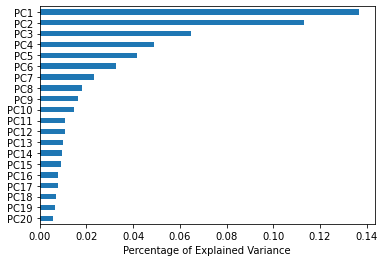

In [31]:
# Check how much variance is explained by all of our PCs
explained_var = pd.Series(pipe.named_steps['pca'].explained_variance_ratio_, index=feature_names)
explained_var.sort_values().plot(kind='barh')
plt.xlabel("Percentage of Explained Variance")
print(explained_var.sum())

How much of the total variance do these contain?

- 


#### So what did we capture?

In [32]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-1.444760,0.062726,5.371685,-2.163971,-1.361499,-0.662249,3.109931,-1.941314,-2.742550,-0.124560,-3.056234,-0.032527,0.782879,-1.878450,-0.797098,-0.076210,-1.483669,-0.306794,-0.039240,0.852804
1,2.458966,6.418345,1.542705,1.363692,-1.869112,-0.939414,1.545690,1.112997,-1.244561,-3.677963,-0.467826,0.734061,2.357401,-1.535757,0.526605,-0.530404,0.347386,-0.608020,-1.075053,-0.333293
2,0.360770,0.277832,2.732029,-3.105924,-0.728588,-1.511495,-2.221124,-0.460236,-1.164649,-3.029225,-0.839583,0.266484,1.347519,-1.831587,-1.479022,-0.365064,-0.912797,-0.278851,-0.713657,0.842420
3,-3.393447,-0.611855,-2.284848,-1.188195,-0.695225,-1.447119,0.705370,2.262296,-0.978687,1.019013,0.435448,-0.377207,-1.058927,-0.349129,-0.634943,-0.034768,0.040688,-0.472082,-0.163437,-0.495661
4,-0.385730,-0.959989,4.543877,-2.397694,-1.654590,-1.428129,-0.710099,0.170535,0.804264,-0.057175,0.299104,1.575985,-0.059049,1.377161,0.188818,0.415918,1.797333,-0.863713,1.655549,-0.766267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,1.069354,5.420934,-1.557212,0.938435,0.537694,-0.451400,-0.207456,-1.433010,-0.537060,1.663846,0.085167,1.383488,1.099255,0.664755,-0.914783,-0.475412,-0.733972,-0.333654,0.438558,-0.878723
10171,-4.996754,-1.405603,-0.107241,2.209427,-2.355092,0.965557,-0.550122,-2.019589,0.526408,-0.378998,0.026527,-0.361667,-0.198668,-0.039500,-0.054085,-0.418350,0.338375,-0.410370,-0.374901,-0.224554
10172,3.668946,-2.954731,-0.860676,0.511957,-0.490520,-1.962673,-1.776651,0.043811,-0.702692,0.173457,-1.196782,-1.955954,-0.463116,0.314633,-1.646149,-0.310228,1.169775,1.462070,-1.489345,-0.341829
10173,-4.138804,-0.926078,-2.109125,-0.603035,-1.281605,-0.252295,-0.052351,3.078653,-0.820522,0.811857,-0.444820,0.406144,0.218409,0.268847,-0.603655,0.581621,-0.495894,-0.793734,0.489095,0.067029


In [33]:
df_pca.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20'],
      dtype='object')

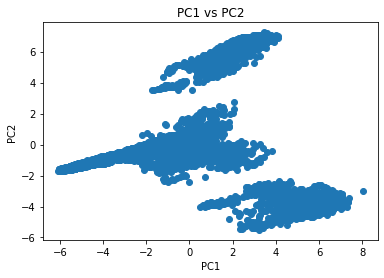

In [34]:
# Plot PC1 vs PC2

x = 'PC1'
y = 'PC2'

plt.scatter(df_pca[x], df_pca[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"{x} vs {y}")
plt.show()


#### Make an Interactive Function for Exploring (!!)

In [35]:
# Make interactive function to show any comparison
from ipywidgets import interact

@interact(x=feature_names, y=feature_names)
def plot_2D_PC(x='PC1', y='PC2'): 
    """Plot two principal components against each other"""
    plt.scatter(df_pca[x], df_pca[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs {y}")
    plt.show()

interactive(children=(Dropdown(description='x', options=('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8…

#### We are only visualizing a small portion of our PC data, let's add another dimension

#### Make an interactive plotly scatter3d

In [36]:
import plotly.express as px

@interact(x=feature_names, y=feature_names, z=feature_names)
def plot_3D_pc(x='PC1', y='PC2', z='PC3'):
    fig = px.scatter_3d(df_pca, x=x, y=y, z=z)
    fig.update_traces(marker={'size': 2})
    return fig

interactive(children=(Dropdown(description='x', options=('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8…

## Now, Clustering!

### Wait - How is clustering different from classification?

>In _classification_ you **know** what groups are in the dataset and the goal is to _**predict**_ class membership accurately.
>
>In _clustering_ you **do not** know which groups are in the dataset and you are trying to _**identify**_ the groups.

### So what do you do with clustering results?

Clustering is often an *informing* step in your analysis. Once clusters are identified, one can:
- Create strategies on how to approach each group differently
- Use cluster membership as an independent variable in a predictive model
- Use the clusters as the _target label_ in future classification models. How would you assign new data to the existing clusters?

### Let's Try Clustering Our PCA-ed Data!

In [37]:
# Imports round 4
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Need scipy for hierarchical clustering visualizations
from scipy.cluster.hierarchy import dendrogram

In [38]:
# Let's start with KMeans! How many clusters...?
model = KMeans(n_clusters=3)

model.fit(df_pca)

KMeans(n_clusters=3)

In [39]:
# Let's explore
model.cluster_centers_

array([[ 1.16532968e+00,  2.94796294e+00,  1.51070419e+00,
        -6.12104164e-01, -5.26377967e-01, -9.19456848e-02,
        -7.27216105e-02, -1.06659488e-01, -2.31134748e-02,
         3.21383805e-02,  5.68945151e-02,  7.57655844e-02,
        -1.14262377e-01,  7.75414686e-02, -8.51724629e-02,
         6.50424392e-02, -7.73616597e-02, -3.18568495e-02,
         2.34557080e-02,  5.15923960e-02],
       [-3.28416423e+00, -7.35182030e-01, -9.41210956e-01,
        -2.47061137e-02,  4.82809798e-01,  4.39995546e-02,
         1.48123973e-02,  7.59324905e-02,  1.19524747e-01,
        -7.28810659e-02,  1.59117008e-03, -1.49614620e-02,
         5.76930918e-02, -6.54864616e-02,  1.26102658e-01,
        -5.52036753e-02,  3.02627211e-02, -4.88404621e-03,
        -1.38058205e-02, -3.20202787e-02],
       [ 5.08308130e+00, -3.86410701e+00, -7.33703991e-01,
         1.19398040e+00, -8.63303132e-02,  7.39925524e-02,
         1.02660385e-01,  3.08654960e-02, -2.20917656e-01,
         1.01116041e-01, -1.0

#### Note! 

You may have different cluster centers - the algorithm is sensitive to starting points.

Even if we set `n_init` to a significant value, it's still a good idea to use `random_state` to ensure repeatable results.

### Choosing the appropriate number for $k$

#### Two metrics we can use: **elbow method** and the **silhouette coefficient**

#### Elbow Method

Elbow method uses the sum of squared error (SSE) calculated from each instance of $k$ to find the best value of $k$.

This is sometimes called the "inertia" of the model, and fitted sklearn $k$-means models have an `inertia_` attribute.

Sometimes you will see the SSE divided by the total sum of squares in the dataset (how far is each point from the center of the entire dataset)

Fewer clusters seems better, but inertia will always decrease with _more_ clusters. Hence the idea of looking for an elbow in the plot of inertia vs. $k$.

In [40]:
model.inertia_

365203.24974170775

Inertia is the sum of squared distances between points and their cluster center.

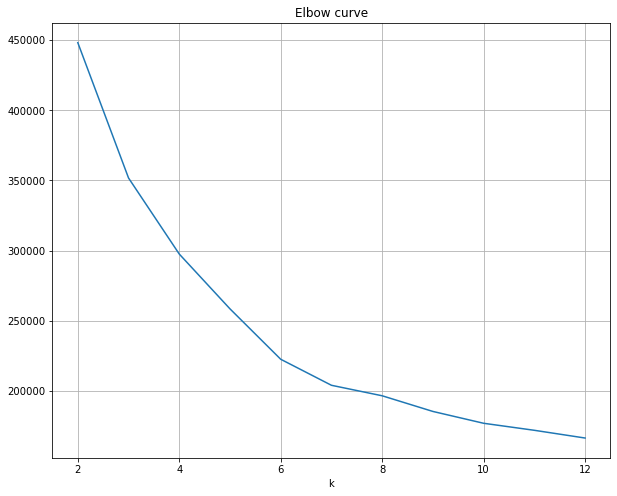

In [41]:
# Specifying the dataset and initializing variables
distortions = []

# Calculate SSE for different K
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, random_state=301)
    kmeans.fit(df_pca)
    distortions.append(kmeans.inertia_)

# Plot values of SSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(range(2, 13), distortions)
ax.grid(True)

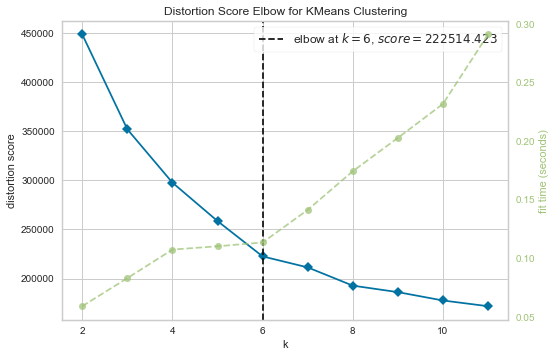

In [42]:
# If yellowbrick works for you...
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,12), timings=True)

visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show()  
plt.show()

#### Silhouette Coefficient

![silo](images/silo2.png)

> **a** refers to the average distance between a point and all other points in that cluster.
>
> **b** refers to the average distance between that same point and all other points in clusters to which it does not belong

It is calculated for each point in the dataset, then averaged across all points for one cumulative score.

The Silhouette Coefficient ranges between -1 and 1. The closer to 1, the more clearly defined are the clusters. The closer to -1, the more incorrect assignment.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html



In [43]:
labels = model.labels_

In [44]:
silhouette_score(df_pca, labels)

0.29932197386118525

In [45]:
silhouette_scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=301)
    kmeans.fit(df_pca)
    labels = kmeans.labels_
    silhouette_scores[k] = silhouette_score(df_pca, labels)

In [46]:
silhouette_scores

{2: 0.24270529902942398,
 3: 0.2978285341301001,
 4: 0.2776929096494598,
 5: 0.2961762895226931,
 6: 0.3377014550317026,
 7: 0.3485617343049777,
 8: 0.3227089488061349,
 9: 0.3222240036022461}

### So - How Many Clusters?

- It depends. There are no right answers, but there are better answers than others


### There's Also Hierarchical Clustering

Hierarchical clustering determines cluster assignments by building a hierarchy. This is implemented by either a bottom-up or a top-down approach:

- **Agglomerative clustering** is the bottom-up approach. It merges the two points that are the most similar until all points have been merged into a single cluster.
- **Divisive clustering** is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain.

These methods produce a tree-based hierarchy of points called a **dendrogram**. Similar to partitional clustering, in hierarchical clustering the number of clusters (k) is often predetermined by the user. Clusters are assigned by cutting the dendrogram at a specified depth that results in k groups of smaller dendrograms.

![dendro](images/dendogram.png)

**Unlike many partitional clustering techniques, hierarchical clustering is a deterministic process, meaning cluster assignments won’t change when you run an algorithm twice on the same input data.**

The **strengths** of hierarchical clustering methods include:

- They often reveal the finer details about the relationships between data objects
- They provide an interpretable dendrogram

The **weaknesses** of hierarchical clustering methods include:

- They’re computationally expensive with respect to algorithm complexity
- They’re sensitive to noise and outliers

From sklearn's documentation: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

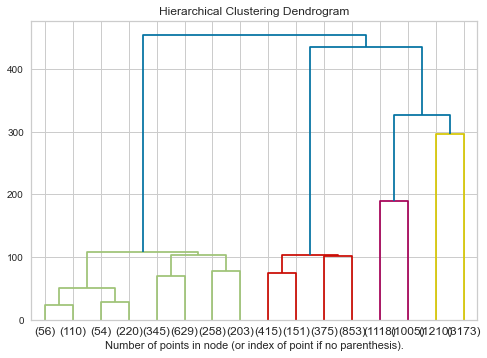

In [47]:
def plot_dendrogram(model, **kwargs):
    """ Create linkage matrix and then plot the dendrogram"""

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_pca)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

-----

## 3) Manipulating Time Series Data

### Data Set Up

Airline Passenger Data: https://www.kaggle.com/rakannimer/air-passengers

(it's a pretty common dataset, available in several different places, but here's a source)

In [48]:
# Imports round 5
from statsmodels.tsa.stattools import adfuller

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

In [49]:
# If you want to install pmdarima (plus a link to the documentation)
# http://alkaline-ml.com/pmdarima/
# !pip install pmdarima

In [50]:
# Read df
air_df = pd.read_csv('data/airline_passengers.csv')

In [51]:
# Check the shape of the data
air_df.shape

(144, 2)

In [52]:
# Check the first 10 rows...
air_df.head(10)

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [53]:
# Let's go ahead and set the index to be a datetime index
# First making it a datetime object
air_df['Month'] = pd.to_datetime(air_df['Month'])

# Now making it our index
air_df.set_index('Month', inplace=True)

In [54]:
# Now let's look at how that impacted the time/index
air_df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [55]:
air_df.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


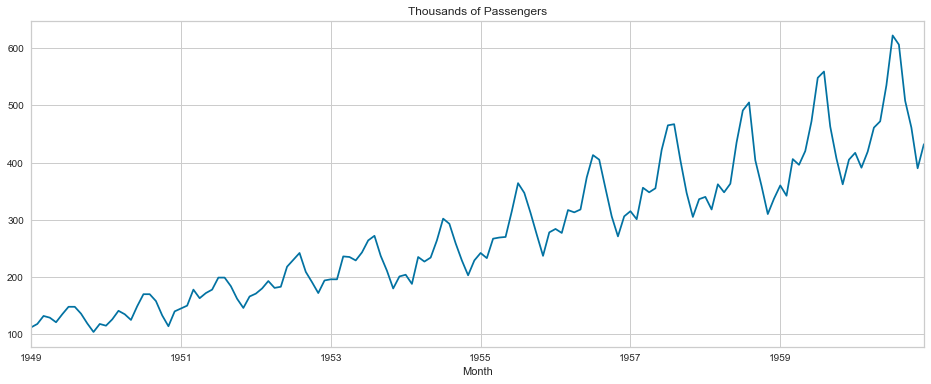

In [56]:
# Let's get a sense of the data
plt.figure(figsize=(16,6))
air_df['Thousands of Passengers'].plot()
plt.title('Thousands of Passengers')
plt.show()

Now we can see the general trends in our data.

Also! This is why we change our data to use the datetime object as the index - makes EVERYTHING easier!

## Changing the frequency of our data 

Also called downsampling or upsampling, depending on whether you're going to a less frequent or more frequent point in time.

[Here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling) is a reference for resampling based on time frequency. (you can find the actual codes you can use as arguments in the resample function [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)).

In [57]:
# Upsampling to a daily cadence
df_daily = air_df.resample('D').mean()

In [58]:
df_daily.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-01-02,NaN
1949-01-03,NaN
1949-01-04,NaN
1949-01-05,NaN


In [59]:
# Ew - nulls!
df_daily.isna().sum()

Thousands of Passengers    4209
dtype: int64

Of course we have nulls though - we took monthly data and tried to make it daily!

But what about downsampling to quarterly?

In [60]:
# Here we're downsampling to quarter
# Note that there are a few different ways to define 'quarter'
df_quarterly = air_df.resample('Q').mean()
df_quarterly.head()

,Thousands of Passengers
Month,
1949-03-31,120.666667
1949-06-30,128.333333
1949-09-30,144.000000
1949-12-31,113.666667
1950-03-31,127.333333


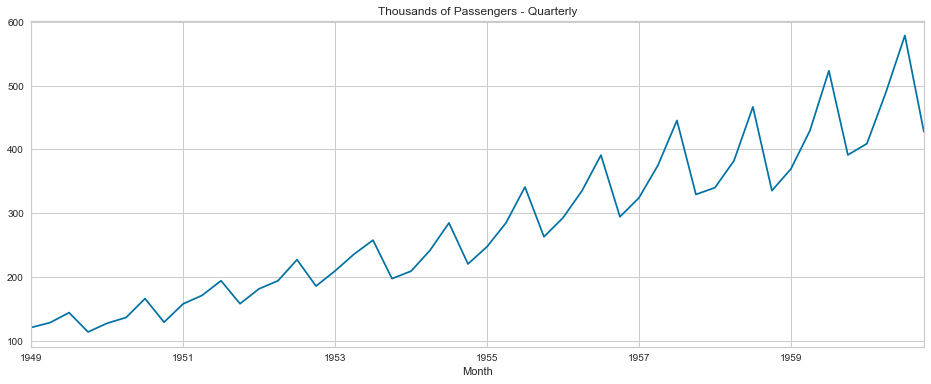

In [61]:
# Again, visualizing the Average Opening price
plt.figure(figsize=(16,6))
df_quarterly['Thousands of Passengers'].plot()
plt.title('Thousands of Passengers - Quarterly')
plt.show()

So, as would make sense, as you change the frequency of your data it changes the granularity (level of detail) that's conveyed.

### Stationarity

Introduction to stationarity from [_Forecasting: Principles and Practice_](https://otexts.com/fpp2/stationarity.html):

> "A stationary time series is one whose properties do not depend on the time at which the series is observed.14 Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.
>
> "Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.
>
> "In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance."

And here's a [useful blog post](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322) on the subject, where I found the below demonstrative image:

![Examples of stationary and non-stationary processes, from the above medium blog](https://miro.medium.com/max/1400/1*tkx0_wwQ2JT7pSlTeg4yzg.png)

#### Why do we want to get a stationary series?

> "Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time."

- [Source](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

Biggest reason: makes the data easier to model!

In [62]:
# Let's  get the rolling mean and rolling standard deviation, using a 12-month window

roll_mean = air_df['Thousands of Passengers'].rolling(window=12, center=False).mean()
roll_std = air_df['Thousands of Passengers'].rolling(window=12, center=False).std()

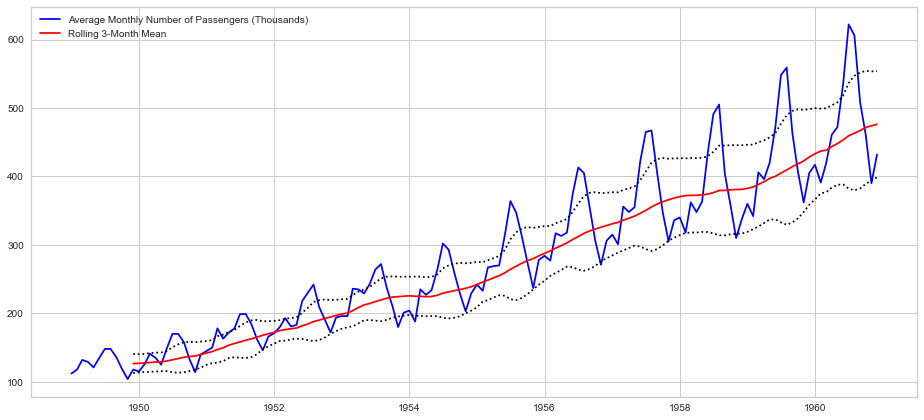

In [63]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(air_df['Thousands of Passengers'], color='blue',
        label='Average Monthly Number of Passengers (Thousands)')

ax.plot(roll_mean, color='red', label='Rolling 3-Month Mean')

ax.plot(roll_mean + roll_std, color='black', linestyle='dotted')
ax.plot(roll_mean - roll_std, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

Do you think this data is stationary? Why or why not?

 - 
 

There's a test for this!

> **Augumented Dickey-Fuller test**: a hypothesis test, where we reject the null hypothesis (that a time series is non-stationary) if the test-statistic is less than the critical value

[Documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for the Dickey-Fuller test in StatsModels

So let's write out our null and alternative hypotheses (remember these??):

Ho = 

Ha = 

In [64]:
# Feed in our column, since the test function expects a series:
adfuller(air_df['Thousands of Passengers'])

(0.815368879206047,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

Let's interpret the output of this test:

- 


In [65]:
# Now that we've determined whether the data is stationary, let's decompose it

# Using the decompose function from pmdarima
# Need to feed it an array, hence the .values attribute
decomposed = decompose(air_df['Thousands of Passengers'].values, 'multiplicative', m=12)

# M? See this: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period

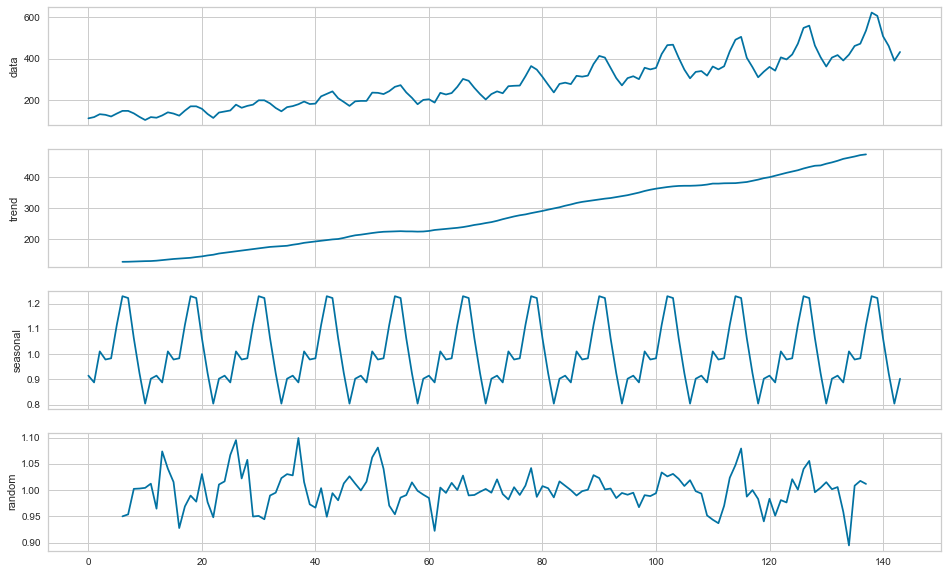

In [66]:
# Plotting the pieces using the arima model again
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the documentation for `pmdarima`'s decompose:: 

> So what is happening when we call `decomposed`?
> 1) The trend is extracted from the signal via a convolution using either a
   SMA or a user-defined filter.
>   
> 2) We remove the effects of the trend from the original signal by either
   subtracting its effects or dividing out its effects for 'additive' or
   'multiplicative' types of decompositions, respectively. We then take the
   mean across all seasons to get the values for a single season. For m=4, we
   expect 4 values for a single season.
>
> 3) We then create the seasonal series by replicating the single season
   until it is the same length of the trend signal.
>
> 4) Lastly to get the random/noise elements of the signal we remove the effects
   of both the trend and seasonal series and we are now left with the
   variation of the original signal that is neither explainable by seasonal
   nor trend effects.
>
> This logic produces a named tuple of the original signal, trend, seasonal, and random components. It is this named tuple that is passed to `decomposed_plot`

#### Additive vs Multiplicative?

It's in the trends of the plots: 

| Additive Example | Multiplicative Example |
| ---------------- | ---------------------- |
| ![from the pmdarima documentation: additive example](images/sphx_glr_example_seasonal_decomposition_001.png) | ![from the pmdarima documentation: multiplicative example](images/sphx_glr_example_seasonal_decomposition_002.png) |

[Source](https://alkaline-ml.com/pmdarima/auto_examples/arima/example_seasonal_decomposition.html)

Can you spot the difference?